In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import requests
import urllib
# !conda install -c conda-forge folium=0.11.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import seaborn as sns
%pylab inline
plt.style.use('fivethirtyeight')
print('Libraries imported.')

Populating the interactive namespace from numpy and matplotlib
Libraries imported.


In [2]:
!wget -q -O 'data/newyork_data.json' https://cocl.us/new_york_dataset 
print('Data downloaded!')

Data downloaded!


In [3]:
with open('data/newyork_polygon.json') as json_data:
    newyork_data = json.load(json_data)
    

In [4]:
ny_df = pd.DataFrame(columns=['Neighborhood','Borough','Longitude','Latitude'])
for ng in newyork_data['features']:
    
    max_ = np.max(np.array(ng['geometry']['coordinates'][0]), axis = 0)
    min_ = np.min(np.array(ng['geometry']['coordinates'][0]), axis = 0)
    coords = min_ + (max_ - min_)/2
    ny_df.loc[-1] = [ng['properties']['neighborhood'],ng['properties']['borough']] + coords.tolist()
        
    ny_df = ny_df.reset_index(drop=True)

ny_df['Borough']  = ny_df.Borough.astype('category')

ny_df['Borough_code'] = ny_df.Borough.cat.codes

In [5]:
ny_df = ny_df.groupby(['Neighborhood']).mean().reset_index()

In [6]:
#Convert long lat to xy-coordinates (linearized)
lat_conv = 0.69
long_conv = 0.52
ny_df['Latitude'] *= lat_conv
ny_df['Longitude'] *= long_conv

## Arrests data

In [7]:
# query = "https://data.cityofnewyork.us/resource/erm2-nwe9.json?$where=created_date between '2020-01-1T00:00:00' and '2020-06-29T00:00:00' and complaint_type='Noise' limit 200000"
# query = "https://data.cityofnewyork.us/resource/qb7u-rbmr.json?$where=CMPLNT_FR_DT between '2019-01-1T00:00:00' and '2020-06-29T00:00:00' limit 20000"
query = "https://data.cityofnewyork.us/resource/8h9b-rp9u.json?$where=arrest_date between '2019-01-01T00:00:00.000' and '2019-12-31T00:00:00.000' limit 1000000"
# query = "https://data.cityofnewyork.us/resource/qb7u-rbmr.json"
# query = "https://data.cityofnewyork.us/resource/erm2-nwe9.json?$where=created_date between '2020-01-1T00:00:00' and '2020-06-29T00:00:00' and complaint_type in ('Noise','Noise - Residential') limit 200000"
# 

In [8]:
arrests = requests.get(query).json()

arrests_df = pd.DataFrame.from_records(arrests)

len(arrests_df)

214617

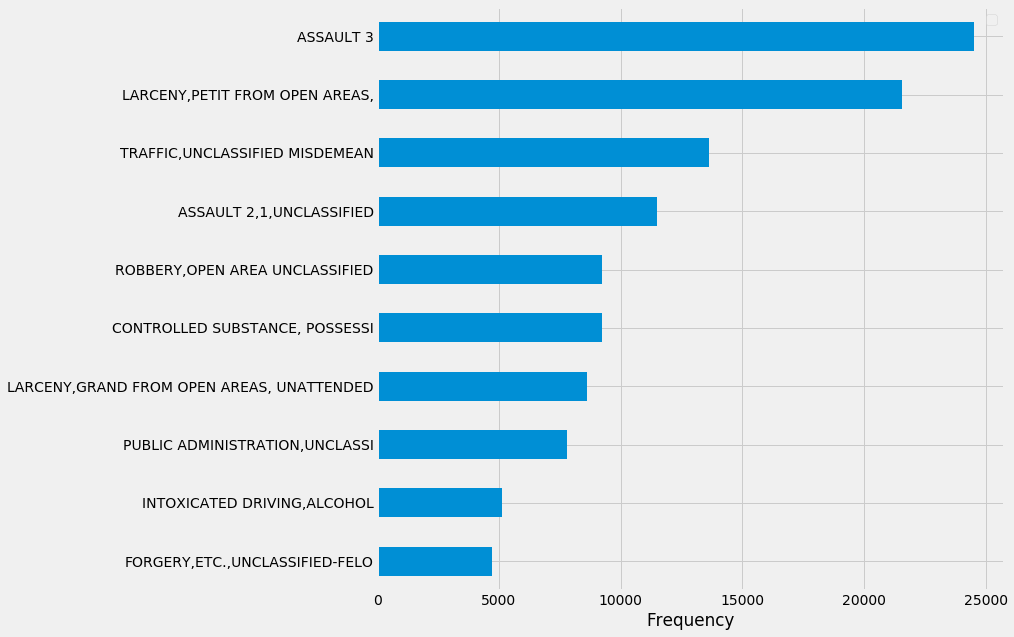

In [9]:
figsize(10,10)
arrests_df.pd_desc.value_counts().to_frame().head(10).sort_values('pd_desc').plot(kind='barh')
legend([])
xlabel('Frequency')
savefig('fig/arrests_freq.png', bbox_inches='tight')
savefig('fig/arrests_freq.pdf')

## Shootings data

In [10]:
query = "https://data.cityofnewyork.us/resource/833y-fsy8.json?$where=occur_date between '2019-01-01T00:00:00.000' and '2019-12-31T00:00:00.000' limit 1000000"

In [11]:
shootings = requests.get(query).json()

shootings_df = pd.DataFrame.from_records(shootings)

len(shootings_df)

1716

In [12]:
shootings_df = pd.DataFrame(np.tile(shootings_df.values,[int(len(arrests_df)/len(shootings_df)),1]), columns = shootings_df.columns)

In [13]:
shootings_df.head()

,incident_key,occur_date,occur_time,boro,precinct,jurisdiction_code,location_desc,statistical_murder_flag,perp_age_group,perp_sex,perp_race,vic_age_group,vic_sex,vic_race,x_coord_cd,y_coord_cd,latitude,longitude,geocoded_column
0,191739126,2019-01-01T00:00:00.000,02:19:00,BRONX,46,2,MULTI DWELL - APT BUILD,False,25-44,M,BLACK HISPANIC,25-44,M,BLACK,1013072,251276,40.85633063300003,-73.89581193099998,"{'type': 'Point', 'coordinates': [-73.89581193..."
1,191739125,2019-01-01T00:00:00.000,05:40:00,BROOKLYN,88,2,MULTI DWELL - PUBLIC HOUS,False,NaN,NaN,NaN,18-24,M,BLACK,991148,192533,40.69514090800004,-73.975125947,"{'type': 'Point', 'coordinates': [-73.97512594..."
2,191739126,2019-01-01T00:00:00.000,02:19:00,BRONX,46,2,MULTI DWELL - APT BUILD,False,25-44,M,BLACK HISPANIC,25-44,M,BLACK,"1,013,072","251,276",40.85633063300003,-73.89581193099998,"{'type': 'Point', 'coordinates': [-73.89581193..."
3,191709964,2019-01-01T00:00:00.000,04:26:00,BROOKLYN,75,2,MULTI DWELL - PUBLIC HOUS,True,NaN,NaN,NaN,25-44,M,BLACK,"1,021,382","181,825",40.665674700000075,-73.86615550299997,"{'type': 'Point', 'coordinates': [-73.86615550..."
4,191709964,2019-01-01T00:00:00.000,04:26:00,BROOKLYN,75,2,MULTI DWELL - PUBLIC HOUS,True,NaN,NaN,NaN,25-44,M,BLACK,1021382,181825,40.665674700000075,-73.86615550299997,"{'type': 'Point', 'coordinates': [-73.86615550..."


In [14]:
arrests_df = arrests_df[['longitude','latitude']]
shootings_df = shootings_df[['longitude','latitude']]

In [15]:
arrests_df = pd.concat([arrests_df,shootings_df])

## Find neighborhood through nearest neighbor

In [23]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(1)

centers = ny_df[['Longitude','Latitude']]

locations = arrests_df[['longitude','latitude']].dropna()
locations['longitude'] = locations['longitude'].astype(float)* long_conv
locations['latitude'] = locations['latitude'].astype(float) * lat_conv
nn.fit(centers)

neighborhood_locations = nn.kneighbors(locations)[1]

neighborhood_locations = ny_df.iloc[neighborhood_locations.flatten()]

In [24]:
call_count = neighborhood_locations.groupby('Neighborhood')['Borough_code'].count().to_frame().rename({'Borough_code':'Arrests'}, axis=1)
call_count['Arrests (log)'] = np.log(call_count.Arrests)/np.log(10)

In [25]:
ny_df = pd.merge(ny_df,call_count, left_on='Neighborhood',right_index=True)

In [26]:
mean_crime =  ny_df.groupby('Neighborhood').mean().mean().Arrests

In [27]:
ny_df['Arrests']/=mean_crime

In [28]:
ny_df.head()
ny_df['Arrests (log)'] = np.log(ny_df.Arrests)/np.log(10)

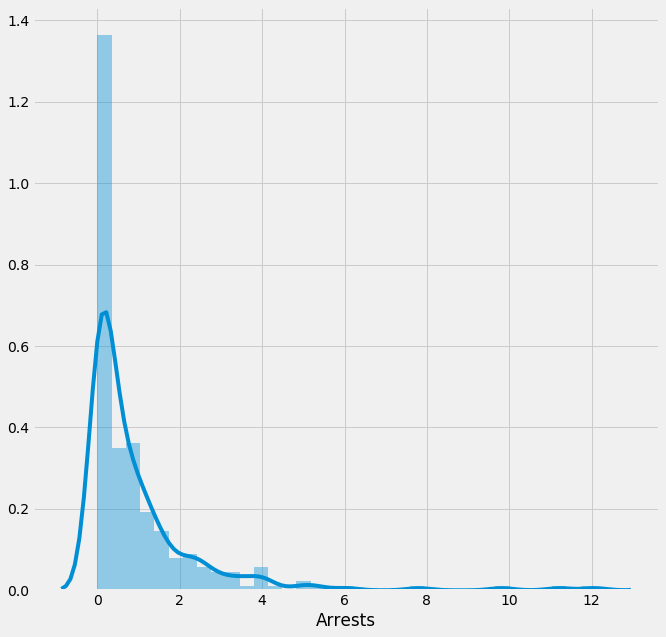

In [29]:
sns.distplot(ny_df['Arrests'])
# xscale('log')

In [30]:
world_map = folium.Map(location=[40.7896239, -73.9598939], zoom_start=11,width='100%',height='100%')



choropleth = folium.Choropleth(geo_data='data/newyork_polygon.json', 
                    data=ny_df, columns=['Neighborhood','Arrests (log)'],key_on='feature.properties.neighborhood',
                    fill_color='YlOrRd', 
                    fill_opacity=0.7, 
                    line_opacity=1,
                    line_color='black',
                    bins=np.arange(-3.5,2,1)).add_to(world_map)


choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['neighborhood'], labels=False)
)

    
world_map

In [31]:
ny_df.to_csv('crime.csv')

In [32]:
world_map.save('fig/crime.html')